## Error analysis of training on the Flickr candidate dataset
This notebook contains the relevant code for reproducing the following figures in the paper "*Image recognition from raw labels collected without annotators*":

- Figure 5-a, 5-b
- Figure 8 (Appendix)

In [1]:
%matplotlib inline
import pathlib
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Figure 5-a: Test performance per class for 135-class subset with semantic overlaps
- Test performance per class, with 95% Clopper-Pearson confidence intervals, when the model is trained on the 135-class subset of the Flickr with semantic overlaps and the original ImageNet images with no overlaps. The results show that some classes suffer from severe performance degradation.

In [2]:
corr_file_imgnet = pathlib.Path.cwd() / 'results/imagenet_err' / 'corr.json'
with open(corr_file_imgnet) as fn:
    corr_dict = json.load(fn)
    
corr_file_flickr = pathlib.Path.cwd() / 'results/flickr_err' / 'corr.json'
with open(corr_file_flickr) as fn:
    corr_dict_flickr = json.load(fn)
    
tiny_wnid_file = (pathlib.Path.cwd() / 'metadata' / 'tiny_classes_to_search.json')
with open(tiny_wnid_file) as fn:
    tiny_dict = json.load(fn)

In [3]:
import scipy.stats
def clopper_pearson(k,n,alpha=0.05):
    """
    http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    alpha confidence intervals for a binomial distribution of k expected successes on n trials
    Clopper Pearson intervals are a conservative estimate.
    """
    lo = scipy.stats.beta.ppf(alpha/2, k, n-k+1)
    hi = scipy.stats.beta.ppf(1 - alpha/2, k+1, n-k)
    if str(hi) == 'nan':
        hi = 1
    return lo, hi

In [4]:
n = 50
wnid_dist = [k for k in corr_dict.keys()]
acc_dist_imgnet = [x/n for x in corr_dict.values()]
acc_dist_flickr = [corr_dict_flickr[k]/50 for k in wnid_dist]

acc_sorted_idx_imgnet = np.argsort(-np.array(acc_dist_imgnet))
acc_sorted_idx_flickr = np.argsort(-np.array(acc_dist_flickr))

In [5]:
sorted_im_acc = np.array(acc_dist_imgnet)[acc_sorted_idx_imgnet]
sorted_fli_acc = np.array(acc_dist_flickr)[acc_sorted_idx_flickr]

im_arr = [(clopper_pearson(int(k*n), n, 0.05)) for k in sorted_im_acc]
fli_arr = [(clopper_pearson(int(k*n), n, 0.05)) for k in sorted_fli_acc]

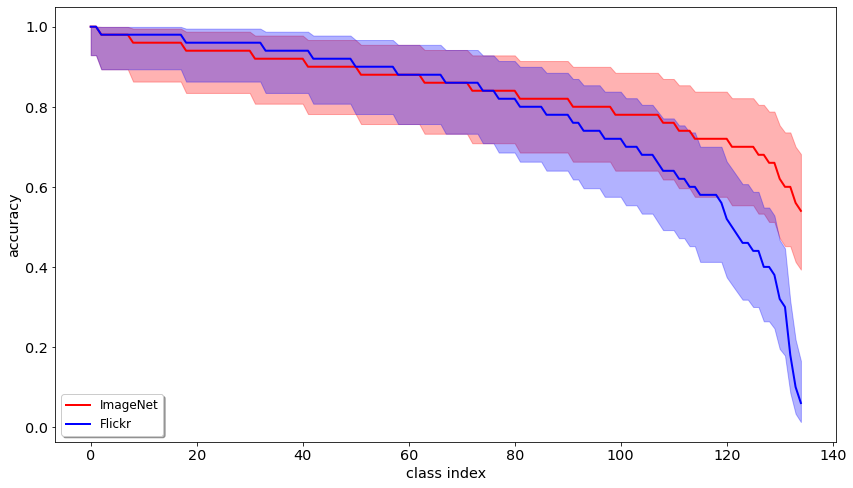

In [6]:
# plot setup
xrange = np.arange(sorted_im_acc.shape[0])
plot_setup = {}
plot_setup['colors'] = ['blue', 'red']


fig = plt.figure(figsize=(14,8))
        
# plot training curvers
ax1 = plt.subplot(111)  
ax1.plot(xrange, sorted_im_acc, lw=2, color='red', label='ImageNet')
ax1.plot(xrange, sorted_fli_acc, lw=2, color='blue', label='Flickr')
ax1.fill_between(xrange, [i[0] for i in im_arr], [i[1] for i in im_arr], alpha=0.3, color='red')
ax1.fill_between(xrange, [i[0] for i in fli_arr], [i[1] for i in fli_arr], alpha=0.3, color='blue')


ax1.legend(loc=3, bbox_to_anchor=(0, 0), fontsize='large',
          frameon=True, fancybox=True, shadow=True, ncol=1)

ax1.set_xlabel('class index')
ax1.set_ylabel('accuracy')

plt.show()

### Figure 5-b: Fraction of the images classified into the correct and incorrect classes
- The following bar plots show the fraction of the test images for a given class that are correctly classified into this class (green) and incorrectly classified into the rest of the other classes (red). Note that a number of classes suffer from severe test performance degradation when the model is trained on the automatically collected Flickr images due to semantic overlaps in the search keywords (ImageNet synsets) or search results.

In [7]:
num_test = 50          # number of test examples, don't change for ImageNet.

# load classification records
npy_file = pathlib.Path.cwd() / 'results/imagenet_conf' / 'confmat.npy'
npy_file_flickr = pathlib.Path.cwd() / 'results/flickr_conf' / 'confmat.npy'

conf_mat = np.load(npy_file)
conf_mat = np.stack([conf_mat[i,:] / num_test for i in range(conf_mat.shape[0])])
conf_mat_diag = np.array([conf_mat[i][i] for i in range(conf_mat.shape[0])])

conf_mat_flickr = np.load(npy_file_flickr)
conf_mat_flickr = np.stack([conf_mat_flickr[i,:] / num_test for i in range(conf_mat_flickr.shape[0])])
conf_mat_diag_flickr = np.array([conf_mat_flickr[i][i] for i in range(conf_mat_flickr.shape[0])])

In [8]:
# sort the confusion matrix by the rows
sorted_idx = np.argsort(conf_mat_diag_flickr)
conf_mat_sorted_flickr = conf_mat_flickr[sorted_idx, ::]

# load index to class wnid mappings
idx2cls_file = pathlib.Path.cwd() / 'metadata' / 'idx2cls.json'
with open(idx2cls_file) as fn:
    idx2cls = json.load(fn)

row_data = []     # this is row based format, not so good for pgfplots
row_data_t = []   # this is the two column format

for cur_idx, cur_row in enumerate(conf_mat_sorted_flickr):
    if cur_row[sorted_idx[cur_idx]] < 1.1:
        cur_list = []
        cur_list.append([idx2cls[str(sorted_idx[cur_idx])], cur_row[sorted_idx[cur_idx]]])
        
        cur_sorted_idx = np.argsort(-cur_row)
        cur_sorted_idx = cur_sorted_idx[cur_sorted_idx != sorted_idx[cur_idx]]
        
        cur_list += [[idx2cls[str(i)], cur_row[i]] for i in cur_sorted_idx]
        row_data.append([i for l in cur_list for i in l])
        row_data_t += cur_list

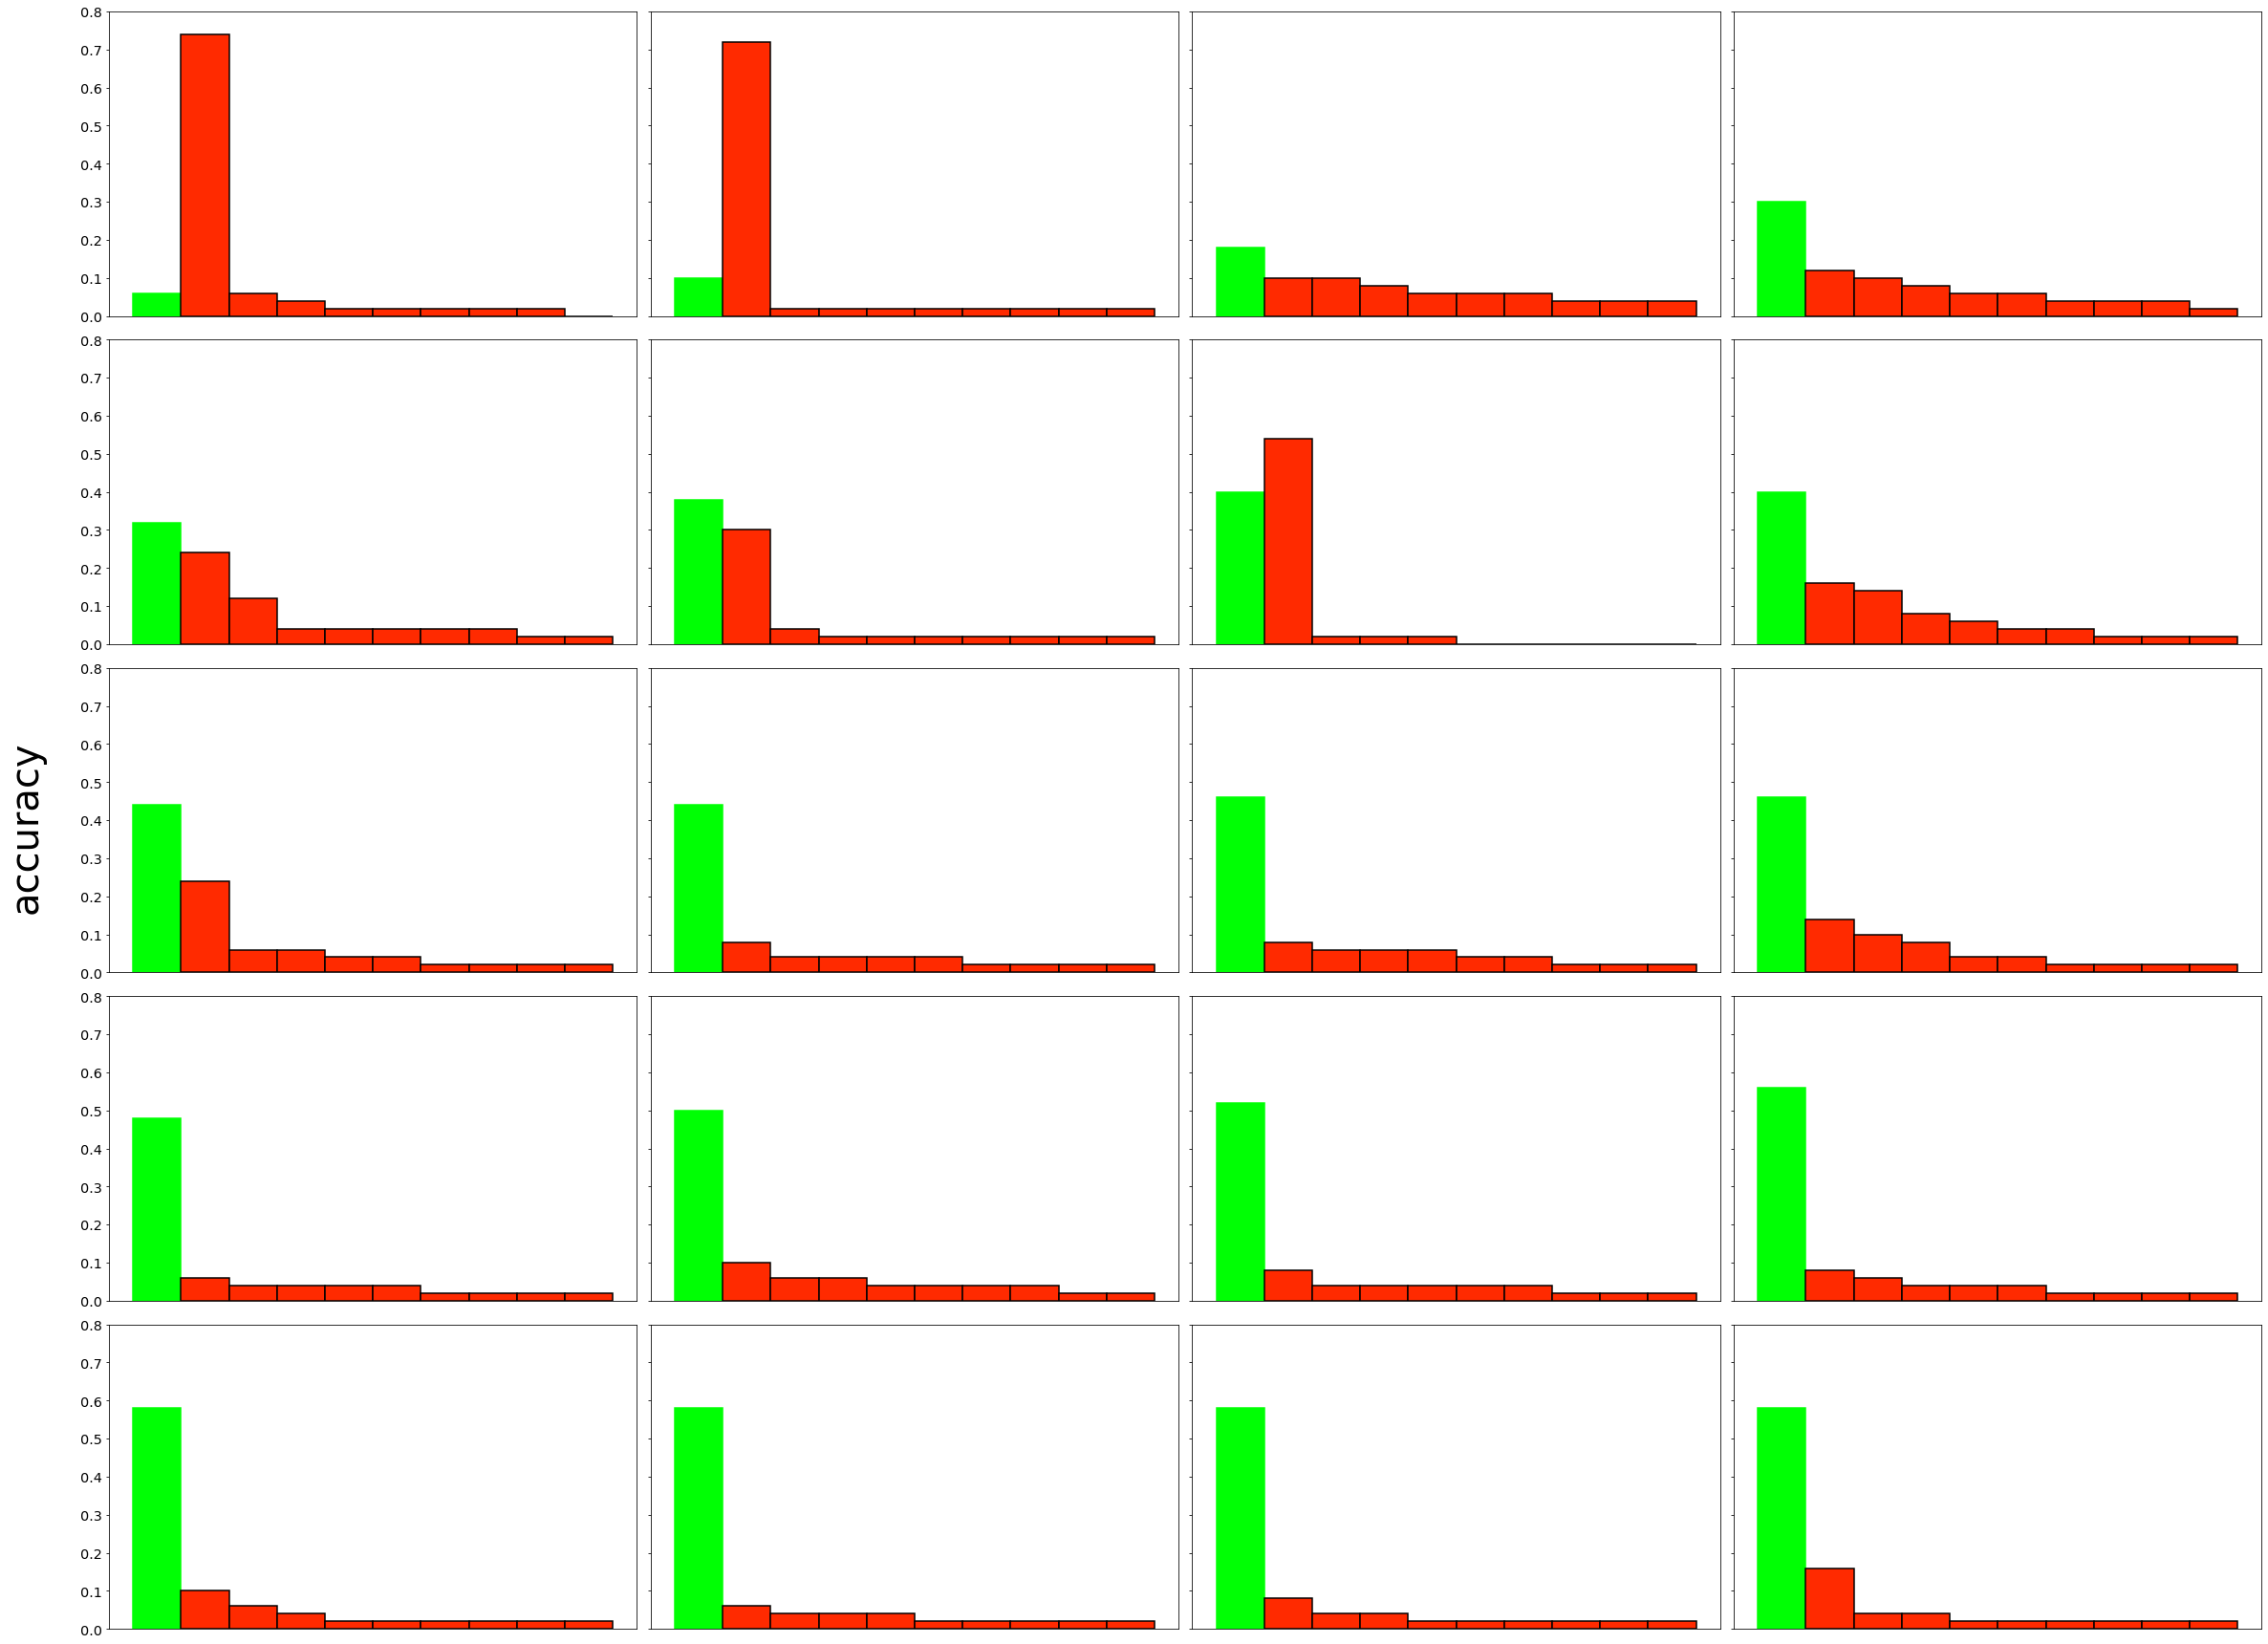

In [9]:
# plot the bar plots
selected_cls = range(20)
err_mat = np.vstack(row_data)[:,1::2].astype(float)

cur_num_cols = int(4)
cur_num_rows = int(np.ceil(len(selected_cls) / cur_num_cols))
fig = plt.figure(figsize=(32,24))
fig.text(-0.02, 0.45, 'accuracy', ha='center', rotation='vertical', fontsize=40)
for cur_idx, cur_cls in enumerate(selected_cls):
    # cur_nonzero = [i for i, err in enumerate(err_mat[cur_cls]) if float(err) > 0]
    cur_nonzero = np.arange(10)

    
    cur_ax = plt.subplot(cur_num_rows, cur_num_cols, int(cur_idx + 1))
    if True: # cur_idx < 5:
        cur_ax.set_ylim([0,0.8])
    cur_width = 0.3
    cur_bars = cur_ax.bar(cur_nonzero*cur_width, err_mat[cur_cls][cur_nonzero], cur_width, 
                          lw = 1.5,
                          edgecolor = 'black',
                          color='#ff2a00')
    cur_bars[0].set_color('#00ff04')
    if (cur_idx % cur_num_cols) == 0:
        cur_ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        cur_ax.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False,
            labelbottom=False) # labels along the bottom edge are off
    
    
    # record the difference of test performance for this class for the training on two datasets
    # cur_ax.set_title(str( err_mat[cur_cls][0] - corr_dict[idx2cls[str(sorted_idx[cur_idx])]]/50))
    

fig.tight_layout()
plt.show()

### Figure 8 (Appendix): Number of images distribution across classes.
- The number of Flickr images collected per class in our candidate training set for the 135 classes, which include the original 100 classes along with the excluded 35 classes. The excluded 35 classes are marked in red. The distribution of these classes in terms of the number of candidate examples indicates that the respective degraded test performance is not directly correlated with the number of training examples.

In [10]:
# load metadata
num_imgs_file = pathlib.Path.cwd() / 'metadata/num_imgs_per_class.txt'
exc_file = pathlib.Path.cwd() / 'metadata/num_imgs_per_class_excluded.txt'

num_imgs_sorted = np.loadtxt(num_imgs_file, dtype=int, usecols = 1, skiprows=1)
excluded = np.loadtxt(exc_file, dtype=int, skiprows=1)

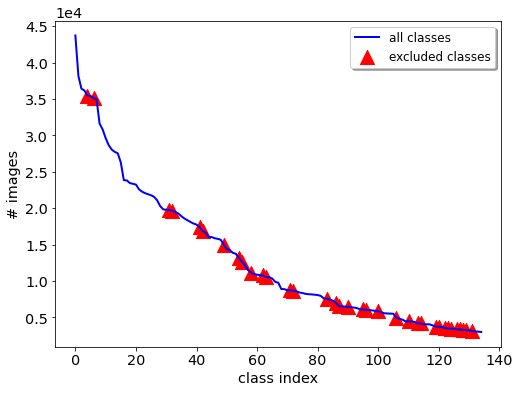

In [11]:
# plot setup
xrange = np.arange(num_imgs_sorted.shape[0])
plot_setup = {}
plot_setup['colors'] = ['blue', 'red']


fig = plt.figure(figsize=(8,6))
        
# plot training curvers
ax1 = plt.subplot(111)  
ax1.plot(xrange, num_imgs_sorted, lw=2, color='blue', label='all classes')
ax1.scatter(excluded[:,0], excluded[:,1], marker='^', s=200, color='red', label='excluded classes')


ax1.legend(loc=1, bbox_to_anchor=(1, 1), fontsize='large',
          frameon=True, fancybox=True, shadow=True, ncol=1)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_xlabel('class index')
ax1.set_ylabel('# images')

plt.show()